Time Series Analysis

In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)


In [2]:
# Specify the path to the CSV file
#csv_file = "data/Mastercard_stock_history.csv"


# Read the CSV file into a DataFrame, specifying the index and parsing dates
dataset = pd.read_csv("Desktop/tcs_stock.csv", index_col="Date", parse_dates=["Date"])

# Print the first few rows of the dataset
print(dataset.head())

           Symbol Series  Prev Close    Open     High      Low     Last  \
Date                                                                      
2015-01-01    TCS     EQ     2558.25  2567.0  2567.00  2541.00  2550.00   
2015-01-02    TCS     EQ     2545.55  2551.0  2590.95  2550.60  2588.40   
2015-01-05    TCS     EQ     2579.45  2581.0  2599.90  2524.65  2538.10   
2015-01-06    TCS     EQ     2540.25  2529.1  2529.10  2440.00  2450.05   
2015-01-07    TCS     EQ     2446.60  2470.0  2479.15  2407.45  2426.90   

              Close     VWAP   Volume      Turnover  Trades  \
Date                                                          
2015-01-01  2545.55  2548.51   183415  4.674345e+13    8002   
2015-01-02  2579.45  2568.19   462870  1.188740e+14   27585   
2015-01-05  2540.25  2563.94   877121  2.248886e+14   43234   
2015-01-06  2446.60  2466.90  1211892  2.989615e+14   84503   
2015-01-07  2417.70  2433.96  1318166  3.208362e+14  101741   

            Deliverable Volume  

In [3]:
print(dataset.describe())

        Prev Close         Open         High          Low         Last  \
count   248.000000   248.000000   248.000000   248.000000   248.000000   
mean   2538.207460  2542.172782  2563.580444  2514.408468  2538.039718   
std      86.829359    87.605699    90.598368    82.952778    86.849305   
min    2319.800000  2319.400000  2343.900000  2315.250000  2321.000000   
25%    2495.312500  2499.500000  2518.900000  2472.100000  2497.500000   
50%    2543.050000  2548.500000  2566.000000  2520.000000  2540.150000   
75%    2592.000000  2594.250000  2615.750000  2567.300000  2593.425000   
max    2776.000000  2788.000000  2812.100000  2721.900000  2785.100000   

             Close         VWAP        Volume      Turnover         Trades  \
count   248.000000   248.000000  2.480000e+02  2.480000e+02     248.000000   
mean   2537.717944  2538.432137  1.172296e+06  2.977489e+14   66873.608871   
std      87.057814    86.813053  6.220635e+05  1.576443e+14   28882.906787   
min    2319.800000  2

In [4]:
dataset.isna().sum()

Symbol                0
Series                0
Prev Close            0
Open                  0
High                  0
Low                   0
Last                  0
Close                 0
VWAP                  0
Volume                0
Turnover              0
Trades                0
Deliverable Volume    0
%Deliverble           0
dtype: int64

In [5]:
# Calculate the threshold for missing values
threshold = 0.2 * len(dataset)

# Iterate over each column
for column in dataset.columns:
    # Check if the column has missing values
    if dataset[column].isna().sum() > 0:
        # If the column is numerical, fill missing values with column mean
        if dataset[column].dtype in ['int64', 'float64']:
            # If the number of missing values is less than the threshold, drop rows
            if dataset[column].isna().sum() < threshold:
                dataset = dataset.dropna(subset=[column])
            # If the number of missing values is greater than or equal to the threshold, fill with column mean
            else:
                column_mean = dataset[column].mean()
                dataset[column].fillna(column_mean, inplace=True)
        # If the column is categorical, drop rows with missing values
        elif dataset[column].dtype == 'object':
            # If the number of missing values is less than the threshold, drop rows
            if dataset[column].isna().sum() < threshold:
                dataset = dataset.dropna(subset=[column])

# Print modified dataset
print("Modified Dataset:")
if dataset.empty:
    print("No data available.")
else:
    print(dataset.head())

Modified Dataset:
           Symbol Series  Prev Close    Open     High      Low     Last  \
Date                                                                      
2015-01-01    TCS     EQ     2558.25  2567.0  2567.00  2541.00  2550.00   
2015-01-02    TCS     EQ     2545.55  2551.0  2590.95  2550.60  2588.40   
2015-01-05    TCS     EQ     2579.45  2581.0  2599.90  2524.65  2538.10   
2015-01-06    TCS     EQ     2540.25  2529.1  2529.10  2440.00  2450.05   
2015-01-07    TCS     EQ     2446.60  2470.0  2479.15  2407.45  2426.90   

              Close     VWAP   Volume      Turnover  Trades  \
Date                                                          
2015-01-01  2545.55  2548.51   183415  4.674345e+13    8002   
2015-01-02  2579.45  2568.19   462870  1.188740e+14   27585   
2015-01-05  2540.25  2563.94   877121  2.248886e+14   43234   
2015-01-06  2446.60  2466.90  1211892  2.989615e+14   84503   
2015-01-07  2417.70  2433.96  1318166  3.208362e+14  101741   

            De

In [6]:
# Check for any remaining missing values
missing_values = dataset.isna().sum().sum()
if missing_values > 0:
    print("Warning: Dataset still contains missing values after cleaning.")

In [7]:
target = 'High'

In [8]:
# Check for categorical variables
categorical_columns = set()

# Add columns with less than 10 unique values
for column in dataset.columns:
    if column != target and dataset[column].nunique() < 10:
        categorical_columns.add(column)

# Append columns with object data type
categorical_columns.update(col for col in dataset.select_dtypes(include=['object']).columns.tolist() if col != target and col != target)

# Identify and add true/false columns
true_false_columns = [col for col in dataset.columns if dataset[col].dtype == 'bool']
categorical_columns.update(true_false_columns)

if len(categorical_columns) > 0:
    print("Categorical columns found:")
    for column in categorical_columns:
        print(column)
    
    # Fit the encoder to the categorical columns
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    encoded_columns = encoder.fit_transform(dataset[list(categorical_columns)])

    # Get the feature names from the encoder
    encoded_feature_names = encoder.get_feature_names_out(input_features=list(categorical_columns))

    # Create a DataFrame with the encoded columns and feature names
    encoded_df = pd.DataFrame(encoded_columns, columns=encoded_feature_names, index=dataset.index)

    # Drop original categorical columns
    dataset.drop(columns=categorical_columns, inplace=True)
    
    # Concatenate encoded columns with dataset
    dataset = pd.concat([dataset, encoded_df], axis=1)
    
# Display the modified dataset
print("Modified Dataset:")
if dataset.empty:
    print("No data available.")
else:
    print(dataset.head())

Categorical columns found:
Symbol
Series
Modified Dataset:
            Prev Close    Open     High      Low     Last    Close     VWAP  \
Date                                                                          
2015-01-01     2558.25  2567.0  2567.00  2541.00  2550.00  2545.55  2548.51   
2015-01-02     2545.55  2551.0  2590.95  2550.60  2588.40  2579.45  2568.19   
2015-01-05     2579.45  2581.0  2599.90  2524.65  2538.10  2540.25  2563.94   
2015-01-06     2540.25  2529.1  2529.10  2440.00  2450.05  2446.60  2466.90   
2015-01-07     2446.60  2470.0  2479.15  2407.45  2426.90  2417.70  2433.96   

             Volume      Turnover  Trades  Deliverable Volume  %Deliverble  
Date                                                                        
2015-01-01   183415  4.674345e+13    8002               52870       0.2883  
2015-01-02   462870  1.188740e+14   27585              309350       0.6683  
2015-01-05   877121  2.248886e+14   43234              456728       0.5207  
20

Outlier Detection

In [9]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Perform KMeans clustering
# Separate features (X) and target variable (y) if necessary
X = dataset.drop(columns=[target])
y = dataset[target]

# Scale the features (X)
scaler = StandardScaler()
scaled_X = scaler.fit_transform(X)

kmeans = KMeans()
kmeans.fit(scaled_X)

# Get cluster centers
centers = kmeans.cluster_centers_

# Calculate distances of each point to its respective cluster center
distances = np.sqrt(np.sum((scaled_X - centers[kmeans.labels_])**2, axis=1))

# Calculate mean and standard deviation of distances
mean_distance = np.mean(distances)
std_distance = np.std(distances)

# Desired threshold as 2 standard deviations from the mean
desired_threshold = mean_distance + 2 * std_distance

# Use the threshold for outlier detection
outliers_mask = distances > desired_threshold

# Save outliers in a new dataset
outliers_dataset = dataset[outliers_mask]

# Print indices and details of outliers
print("Indices of outliers:", np.where(outliers_mask)[0])
print("Details of outliers:")
print(outliers_dataset)

# Remove outliers from the original dataset
dataset = dataset[~outliers_mask]

Indices of outliers: [  0  11  20  43  91 129 188 194 214 225 232 243 244]
Details of outliers:
            Prev Close    Open     High      Low     Last    Close     VWAP  \
Date                                                                          
2015-01-01     2558.25  2567.0  2567.00  2541.00  2550.00  2545.55  2548.51   
2015-01-16     2539.10  2543.7  2545.00  2484.30  2526.00  2532.15  2511.39   
2015-01-30     2544.65  2560.7  2575.00  2470.00  2484.00  2482.05  2494.94   
2015-03-04     2776.00  2788.0  2812.10  2715.65  2740.00  2746.00  2763.04   
2015-05-18     2511.15  2514.1  2525.25  2497.10  2515.15  2520.40  2505.41   
2015-07-09     2595.10  2595.0  2598.25  2506.65  2529.35  2522.50  2540.37   
2015-10-05     2644.60  2652.7  2770.00  2652.70  2719.90  2711.65  2711.39   
2015-10-13     2592.60  2602.8  2612.00  2567.60  2586.85  2598.55  2589.61   
2015-11-11     2458.15  2475.0  2475.00  2450.00  2472.00  2468.80  2467.45   
2015-11-30     2353.35  2365.0  239

In [10]:
# Extract the first date
first_date = dataset.index[0]
tstart = first_date.replace(year=first_date.year).strftime('%Y-%m-%d')

# Calculate the 60th percentile of the data
quantile_date = dataset.index[int(len(dataset) * 0.7)]
tend = quantile_date.replace(year=quantile_date.year).strftime('%Y-%m-%d')

print("tstart:", tstart)
print("tend:", tend)


tstart: 2015-01-02
tend: 2015-09-04


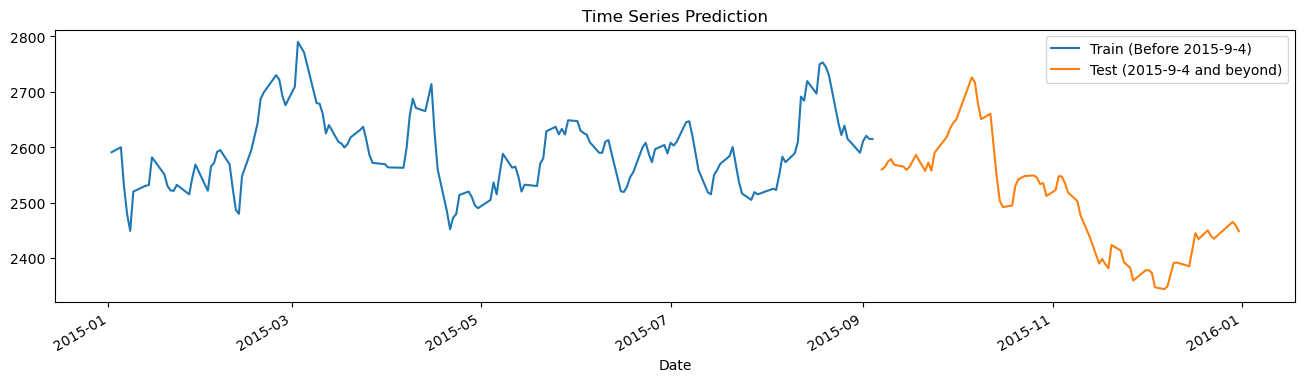

In [12]:
tstart_year = 2015
tstart_month = 1
tstart_day = 2

tend_year = 2015
tend_month = 9
tend_day = 4

def train_test_plot(dataset, tstart_year, tstart_month, tstart_day, tend_year, tend_month, tend_day):
    tstart = f"{tstart_year}-{tstart_month}-{tstart_day}"
    tend = f"{tend_year}-{tend_month}-{tend_day}"
    
    dataset.loc[tstart:tend, target].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend_year}-{tend_month}-{tend_day + 1}":, target].plot(figsize=(16, 4), legend=True)
    
    plt.legend([f"Train (Before {tend})", f"Test ({tend} and beyond)"])
    plt.title("Time Series Prediction")
    plt.show()

train_test_plot(dataset, tstart_year, tstart_month, tstart_day, tend_year, tend_month, tend_day)

In [13]:
def train_test_split(dataset, tstart_year, tstart_month, tstart_day, tend_year, tend_month, tend_day):
    tstart = f"{tstart_year}-{tstart_month}-{tstart_day}"
    tend = f"{tend_year}-{tend_month}-{tend_day}"
    
    train = dataset.loc[tstart:tend, target].values
    test = dataset.loc[f"{tend_year}-{tend_month}-{tend_day + 1}":, target].values
    
    return train, test

training_set, test_set = train_test_split(dataset, tstart_year, tstart_month, tstart_day, tend_year, tend_month, tend_day)

In [14]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [15]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1
# split into samples
X_train, y_train = split_sequence(training_set_scaled, n_steps)


In [16]:
# Reshaping X_train for model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)

GRU Model

In [17]:
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Sequential

# The GRU architecture
model_gru = Sequential()
model_gru.add(GRU(units=125, activation="tanh", input_shape=(n_steps, features)))
model_gru.add(Dense(units=1))
model_gru.add(Dropout(0.05))

# Compiling the model
model_gru.compile(optimizer="RMSprop", loss="mse")

model_gru.summary()

/Users/jennawilson/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 125)            │        48,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           126 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1237 
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0382
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0314
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0425
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0278
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0282
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0194
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0231
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0225
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0225
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0315
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0243
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0252
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0136
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0211
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━

Results

In [19]:
dataset_total = dataset.loc[:,target]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_target = model_gru.predict(X_test)
#inverse transform the values
predicted_target = sc.inverse_transform(predicted_target)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


In [20]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Time Series Prediction")
    plt.xlabel("Time")
    plt.ylabel("Target")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


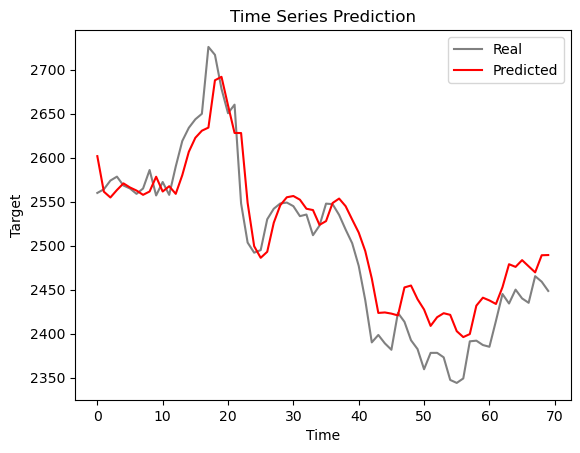

In [21]:
plot_predictions(test_set,predicted_target)

In [22]:
return_rmse(test_set,predicted_target)

The root mean squared error is 36.16.
